# Evaluate model for Vietnamese Stock Env

In [1]:
import os
from pathlib import Path
path = Path(os.getcwd())
os.chdir(path.parent.absolute())

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import pandas_ta as ta
from stable_baselines3.dqn import DQN
from stable_baselines3.ppo import PPO
import gym
import matplotlib.pyplot as plt
from stable_baselines3.common.evaluation import evaluate_policy
import mt4_hst
import stock_env
from stock_env.utils import *
from stock_env.envs.vn_stock_env import VietnamStockEnv
from stock_env.feature.feature_extractor import *
from stable_baselines3.common.env_checker import check_env
%matplotlib inline

In [2]:
env = 'MultiStockContinuousEnv'
algo = 'ppo'
tickers = "FPT SSI VNM".split()
path = "../stock_datasets/"
feature_extractor = TrendFeatures()
name = f"{algo}_{env}_{feature_extractor.__class__.__name__}"
# name = 'ppo_MultiStockContinuousEnv_TrendFeatures'

# Total Portfolio


    Annual return     :  7.11%
    Cumulative return :  24.15%
    Sharpe ratio      :  0.82
    Maximum Drawdown  : -18.11%
    Annual Volatility :  8.85%
    Value-At-Risk     :  nan%
    


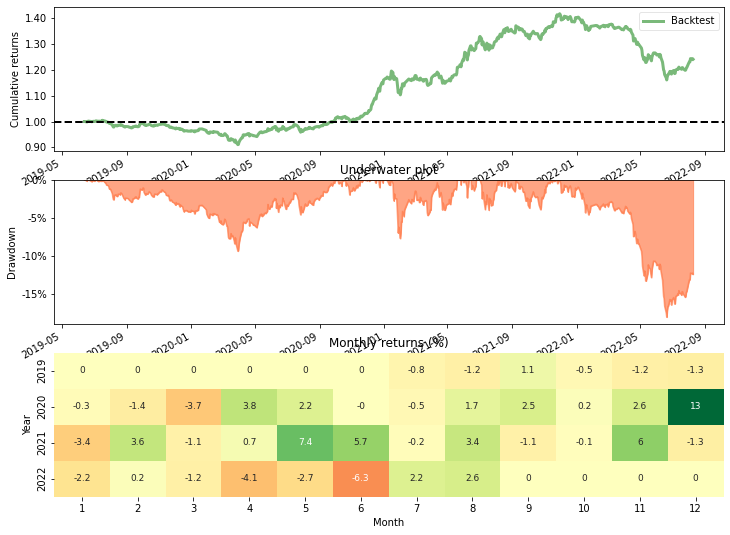

In [3]:
total_name = f'histories_{name}'
df = pd.read_csv(f'temp/history/{total_name}.csv')
df.sort_values(by='time', inplace=True)
df.index = pd.to_datetime(df['time'])
portfolio_value = df['total_portfolio_value']
create_performance(portfolio_value.pct_change())

# Ticker history

In [14]:
ticker = 'SSI'
ticker_name = f'ticker_history_{ticker}_{name}'
df = pd.read_csv(f'temp/history/{ticker_name}.csv')
df.sort_values(by='time', inplace=True)
df.index = pd.to_datetime(df['time'])
portfolio_value = df['portfolio_value']


    Annual return     :  18.89%
    Cumulative return :  72.51%
    Sharpe ratio      :  0.92
    Maximum Drawdown  : -34.19%
    Annual Volatility :  21.45%
    Value-At-Risk     :  nan%
    


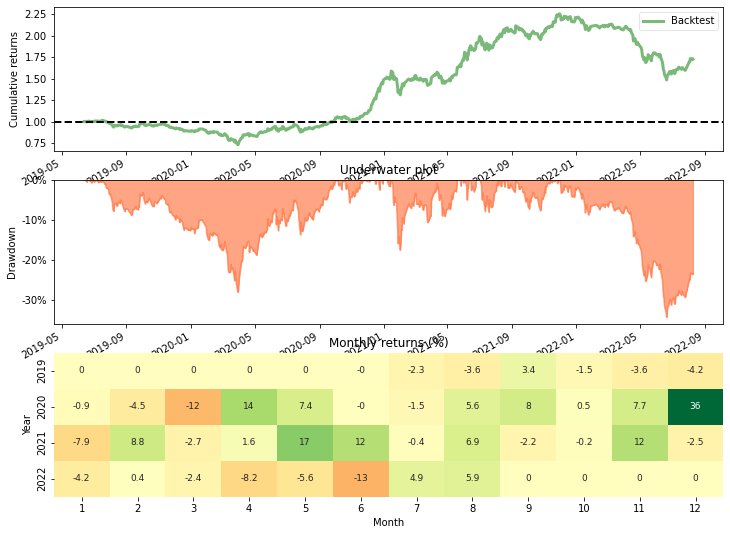

In [15]:
create_performance(portfolio_value.pct_change())

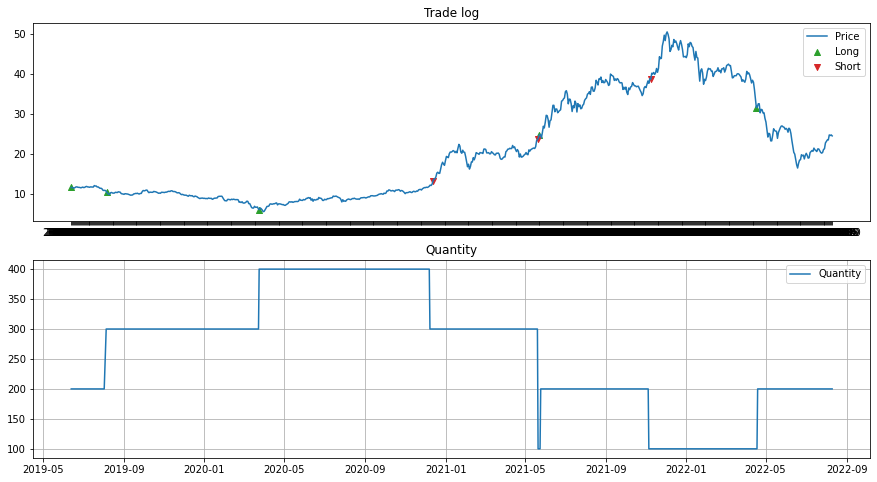

In [16]:
plot_trade_log_v2(df)